---
# Imports
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

plt.rc('figure', figsize=(13, 6))
plt.rc('font', size=13)

---
# Acquire
---

## full data import

In [41]:
# %%time
# df = pd.read_csv('used_cars_data.csv')

In [43]:
# df.shape

---
Maybe only keep cities with a lot of data in TX
- San Antonio, 
- Houston
- Dallas
- Austin
- El Paso?
- Arlington (is this the Arlington in TX?)
- Fort Worth

In [44]:
# df = df[(df.city == 'San Antonio') |
#         (df.city == 'Houston') |
#         (df.city == 'Dallas') |
#         (df.city == 'Austin') |
#         (df.city == 'El Paso') |
#         (df.city == 'Arlington') |
#         (df.city == 'Fort Worth')]

In [45]:
# df.shape

---
Export .csv here to do rest of work with

In [46]:
# df.to_csv('texas_car_data.csv')

---
## Only TX cars import
---

In [274]:
%%time
df = pd.read_csv('texas_car_data.csv', index_col=0)

CPU times: user 3.19 s, sys: 354 ms, total: 3.54 s
Wall time: 3.59 s


In [ ]:
df = df.reset_index(drop=True) # reset index for this subset of the dataset

In [275]:
df.shape

(122842, 66)

In [276]:
df.head(1)

,vin,back_legroom,bed,bed_height,bed_length,body_type,cabin,city,city_fuel_economy,combine_fuel_economy,...,transmission,transmission_display,trimId,trim_name,vehicle_damage_category,wheel_system,wheel_system_display,wheelbase,width,year
139229,JHMFC1F73JX018575,37.4 in,NaN,NaN,NaN,Sedan,NaN,Fort Worth,32.0,NaN,...,CVT,Continuously Variable Transmission,t76411,Touring,NaN,FWD,Front-Wheel Drive,106.3 in,70.8 in,2018


---
# Prepare
---

## Quick clean for MVP

In [277]:
# just curious to see if this is even really necessary. How many duplicates even are there?
df.duplicated().sum()

0

In [278]:
df = df.drop_duplicates()

In [279]:
df.shape

(122842, 66)

In [280]:
df.dropna().shape
# cannot drop them all since all rows have at least one null value

(0, 66)

In [281]:
df.shape

(122842, 66)

---

## More nuanced prep involving imputation

In [282]:
def nulls_by_col(df):
    '''
    Takes in df and shows count of how many rows are null and percentage of total rows that are null
    '''
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    prcnt_miss = round(num_missing / rows * 100, 2)
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 'percent_rows_missing': prcnt_miss})
    return cols_missing

In [283]:
nulls_cols = nulls_by_col(df)

In [284]:
nulls_cols[nulls_cols.percent_rows_missing > 50]

,num_rows_missing,percent_rows_missing
bed,121639,99.02
bed_height,104915,85.41
bed_length,104915,85.41
cabin,120703,98.26
combine_fuel_economy,122842,100.00
fleet,62167,50.61
frame_damaged,62167,50.61
has_accidents,62167,50.61
isCab,62167,50.61
is_certified,122842,100.00


In [285]:
nulls_cols[nulls_cols.percent_rows_missing > 50].shape

(16, 2)

**All of these columns will be dropped**

In [286]:
def nulls_by_row(df):
    '''
    Takes in df and shows count of how many columns are null and percentage of total columns that are null and value count of each unique combo
    '''
    num_missing = df.isnull().sum(axis=1)
    prcnt_miss = round(num_missing / df.shape[1] * 100, 2)
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': prcnt_miss})\
    .reset_index()\
    .groupby(['num_cols_missing', 'percent_cols_missing']).count()\
    .rename(columns={'index': 'num_rows'}).reset_index()
    return rows_missing

In [287]:
nulls_rows = nulls_by_row(df)

In [288]:
nulls_rows[nulls_rows.percent_cols_missing > 50]

,num_cols_missing,percent_cols_missing,num_rows
30,34,51.52,1131
31,35,53.03,668
32,36,54.55,266
33,37,56.06,322
34,38,57.58,539
35,39,59.09,299
36,40,60.61,54
37,41,62.12,55
38,42,63.64,25


In [289]:
nulls_rows[nulls_rows.percent_cols_missing > 50].num_rows.sum()

3359

**3359 rows will be dropped (if we were looking at original df, but in function, columns are dropped first, so %s will change and less rows will be dropped)**

In [290]:
def handle_missing_values(df, prop_required_columns=0.5, prop_required_row=0.5):
    '''
    Takes in df and thresholds for null proportions in each column and row and returns df with only columns and rows below threshold
    '''
    threshold = int(round(prop_required_columns * len(df.index), 0))
    df = df.dropna(axis=1, thresh=threshold)
    threshold = int(round(prop_required_row * len(df.columns), 0))
    df = df.dropna(axis=0, thresh=threshold)
    return df

In [291]:
df.shape

(122842, 66)

In [292]:
%%time
df = handle_missing_values(df)

CPU times: user 417 ms, sys: 39.8 ms, total: 457 ms
Wall time: 461 ms


In [293]:
df.shape

(122816, 50)

In [294]:
122_842 - 122_816

26

In [367]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122816 entries, 0 to 122841
Data columns (total 42 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   body_type             122357 non-null  object 
 1   city                  122816 non-null  object 
 2   city_fuel_economy     103714 non-null  float64
 3   daysonmarket          122816 non-null  int64  
 4   engine_displacement   116188 non-null  float64
 5   franchise_dealer      122816 non-null  int64  
 6   franchise_make        122816 non-null  object 
 7   fuel_tank_volume      122816 non-null  float64
 8   fuel_type             119261 non-null  object 
 9   height                122816 non-null  float64
 10  highway_fuel_economy  103714 non-null  float64
 11  horsepower            116188 non-null  float64
 12  interior_color        122816 non-null  object 
 13  is_new                122816 non-null  bool   
 14  latitude              122816 non-null  float64
 15  

---
#### Initial Ideas/Thoughts about columns:
- VIN
    - Keep as ID? Or just use pandas ID
    - Could use VIN to try to look up vehicle and get more data, but would be beyond scope of this project
    - Drop
- back_legroom
    - Has a lot of data, measurement in inches, but formatted as string, don't think it will be good predictor
    - Drop
- body-type
    - 9 categories
    - keep
- city
    - 7 cities
    - keep
- city_fuel_economy
    - looks like there are some outliers here
    - remove outliers and keep
- daysonmarket
    - Also has outliers (are they?)
    - Should I remove these?
    - Don't think it will be great predictor
    - Keep for now
- dealer_zip
    - 249 values
    - use lat and long instead or city
    - Drop
- description
    - long text description
    - drop
- engine_cylinders
    - 31 values
    - Maybe simpify just to number of cylinders?
    - Drop for now
    - With more time, I could pull out different categorical/numerical columns from this one column to add features, too much packed into one column
- engine_displacement
    - Maybe some outliers
    - keep for now
- engine_type
    - identical data to engine_cylinders
    - drop for now
- exterior_color
    - 4310 values
    - Could try to clean this column up but would take time
    - drop for now
- franchise_dealer
    - no nulls
    - bool
    - keep for now
        - convert to 1 or 0
- franchise_make
    - 39 values
    - keep for now
    - Keep top 6 categories and classify all others as "other"
- front_legroom
    - Has a lot of data, measurement in inches, but formatted as string, don't think it will be good predictor
    - Drop
- fuel_tank_volume
    - currently string
    - format and convert to float
    - keep converted version
- fuel_type
    - 7 categories
    - Keep for now
    - Maybe narrow down number of categories
        - gas or other?
- height
    - currently string, same process as fuel tank volume
    - keep for now
    - drop later if not useful
 - highway_fuel_economy
     - keep
     - maybe remove outliers later
- horsepower
    - keep
    - outliers?
- interior_color
    - 4471 different colors here
    - Could clean up, not for MVP
    - drop
- is_new
    - about 50/50
    - whether or not vehicle waslaunched less than 2 years ago
    - no nulls
    - keep
        - convert to 1 or 0
- 

In [370]:
# take a look 
df.is_new.isna().sum()

0

In [372]:
df.is_new.value_counts()

True     63352
False    59464
Name: is_new, dtype: int64

In [373]:
df.is_new = np.where(df.is_new == True, 1, 0)

In [374]:
df.is_new.value_counts()

1    63352
0    59464
Name: is_new, dtype: int64

---
### Choose columns to keep/drop
---

In [355]:
df = pd.read_csv('texas_car_data.csv', index_col=0)
df = df.reset_index(drop=True) # reset index for this subset of the dataset
df = df.drop_duplicates()
df = handle_missing_values(df)


# to drop all at once as I go through if I have to reset df
cols_to_drop = [
    'vin',
    'back_legroom',
    'dealer_zip',
    'description',
    'engine_cylinders',
    'engine_type',
    'exterior_color',
    'front_legroom',
    'interior_color',
    'interior_color',
    ''
]

# drop all columns above
df = df.drop(columns=cols_to_drop)

In [356]:
# final list of cols to keep
cols_to_keep = [
    'body_type',
    'city',
    'city_fuel_economy',
    'daysonmarket',
    'engine_displacement',
    'franchise_dealer',
    'franchise_make',
    'fuel_tank_volume',
    'fuel_type',
    'height',
    'highway_fuel_economy',
    'horsepower',
    ''
]

In [357]:
# franchise_make
top_six = ['Ford', 'Chevrolet', 'Toyota', 'Honda', 'Nissan', 'Jeep']

df.franchise_make = df.franchise_make.apply(lambda x: x if x in top_six else 'Other')

# df.franchise_make = np.where(df.franchise_make in top_six, df.franchise_make, 'Other')

In [358]:
# franchise_dealer
df.franchise_dealer = np.where(df.franchise_dealer == True, 1, 0)

In [359]:
# fuel_tank_volume
df.fuel_tank_volume = df.fuel_tank_volume.str.split(' ', expand=True)[0]
df.fuel_tank_volume = pd.to_numeric(df.fuel_tank_volume, errors='coerce')
df.fuel_tank_volume = df.fuel_tank_volume.fillna(round(df.fuel_tank_volume.mean(),2))

In [360]:
# height
df.height = df.height.str.split(' ', expand=True)[0]
df.height = pd.to_numeric(df.height, errors='coerce')
df.height = df.height.fillna(round(df.height.mean(),2))

In [ ]:
# is_new
df.is_new = np.where(df.is_new == True, 1, 0)

---

In [166]:
df = df.drop(columns='front_legroom')

---

#### Numerical 

In [361]:
# pull list of numeric columns based on current formatting
df.select_dtypes('number').columns.tolist()

['city_fuel_economy',
 'daysonmarket',
 'engine_displacement',
 'franchise_dealer',
 'fuel_tank_volume',
 'height',
 'highway_fuel_economy',
 'horsepower',
 'latitude',
 'listing_id',
 'longitude',
 'mileage',
 'price',
 'savings_amount',
 'seller_rating',
 'sp_id',
 'year']

In [362]:
len(df.select_dtypes('number').columns.tolist())

17

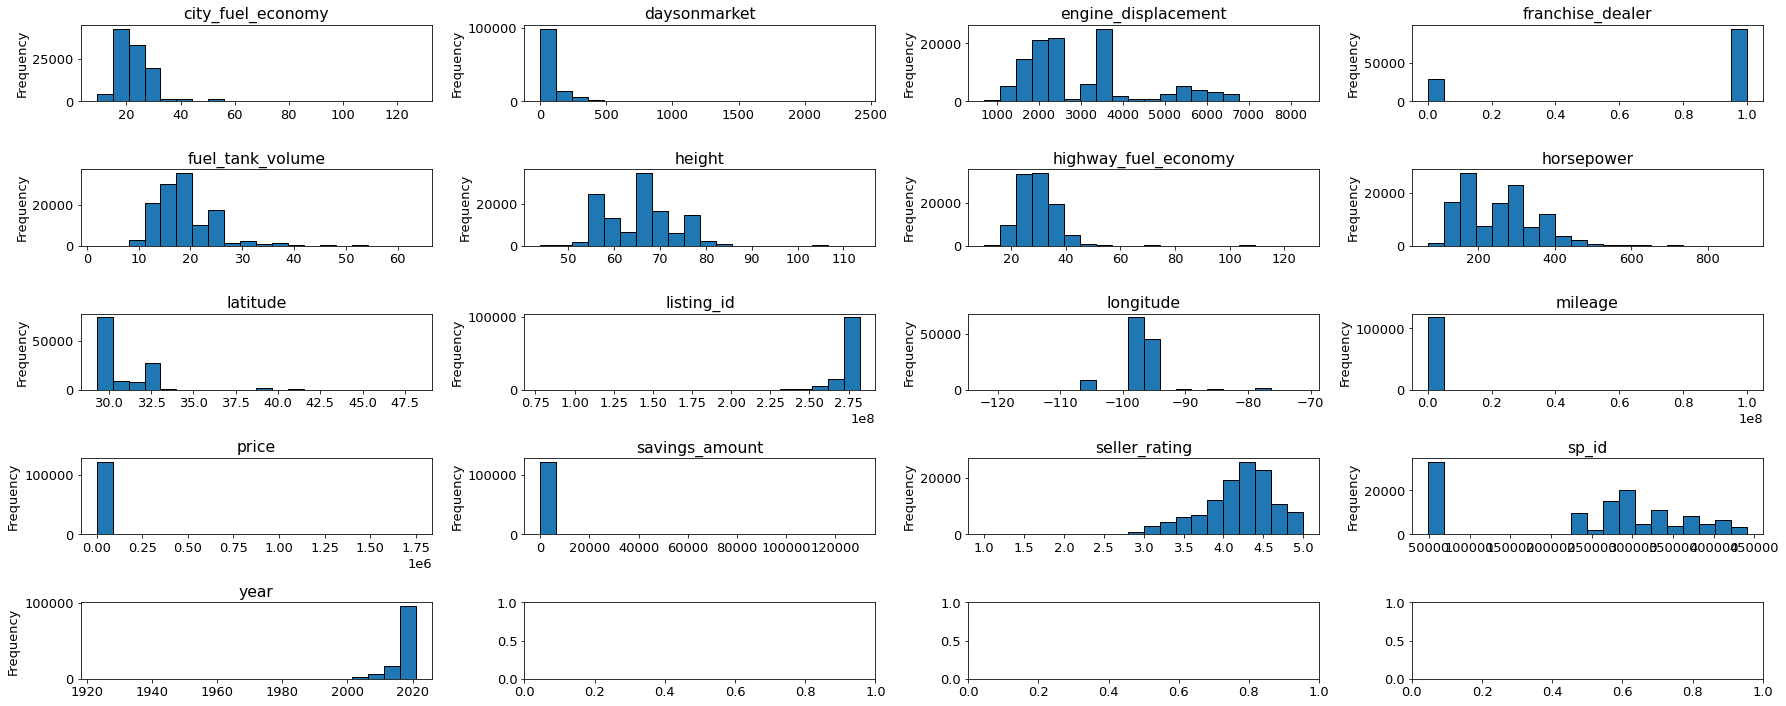

In [363]:
# take a look at remaining column distributions
# let's take a look at the distributions of the continuous variables
fig, axs = plt.subplots(5, 4, sharey=False, figsize=(25, 10))
axe = axs.ravel()
for i, c in enumerate(df.select_dtypes('number').columns):
    df[c].plot.hist(ax=axe[i],title=c, ec='black', bins=20)
    plt.tight_layout()

#### Categorical 

In [364]:
len(df.select_dtypes('object').columns.tolist())

24

In [365]:
cat_cols = df.select_dtypes('object').columns.tolist()

In [366]:
for cat in cat_cols:
    print(cat)
    print('-----------------')
    print(df[cat].value_counts(normalize=True))
    print('-----------------')


body_type
-----------------
SUV / Crossover    0.459508
Sedan              0.264546
Pickup Truck       0.162026
Coupe              0.030624
Hatchback          0.027861
Minivan            0.024527
Van                0.010968
Wagon              0.010845
Convertible        0.009096
Name: body_type, dtype: float64
-----------------
city
-----------------
Houston        0.356289
San Antonio    0.203101
Dallas         0.119211
Austin         0.115783
El Paso        0.079126
Arlington      0.069616
Fort Worth     0.056874
Name: city, dtype: float64
-----------------
franchise_make
-----------------
Other        0.601941
Ford         0.099156
Chevrolet    0.079053
Toyota       0.069405
Honda        0.060318
Nissan       0.048357
Jeep         0.041770
Name: franchise_make, dtype: float64
-----------------
fuel_type
-----------------
Gasoline                  0.896035
Flex Fuel Vehicle         0.051677
Hybrid                    0.023830
Diesel                    0.015663
Biodiesel               

---
#### Bool 
---

In [80]:
len(df.select_dtypes('bool').columns.tolist())

2

In [120]:
bool_cols = df.select_dtypes('bool').columns.tolist()

In [121]:
for col in bool_cols:
    print(col)
    print('-----------------')
    print(df[col].value_counts(normalize=True))
    print('-----------------')

franchise_dealer
-----------------
True     0.769647
False    0.230353
Name: franchise_dealer, dtype: float64
-----------------
is_new
-----------------
True     0.515829
False    0.484171
Name: is_new, dtype: float64
-----------------


---

#### scratchpad area